<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/AssignmentModule6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6 - Dimensionality Reduction with PCA, Kernel PCA and FA(Factor Analysis)

Our goal is to explore different tools for reducing the number of dimensions in our high-dimensional traffic flow dataset. Each technique has a unique approach to identifying and preserving the most important patterns and information within the data:

PCA finds components that maximize explained variance.
Kernel PCA extends this to discover non-linear patterns.
FA models the data to uncover hidden latent factors that explain feature correlations.
We will follow a common workflow for each:

Standardize the data (a crucial step for PCA and Kernel PCA, and highly beneficial for FA).
Apply the tool to project our data onto a new, lower-dimensional subspace.
Analyze the results to understand what information is preserved and how to interpret it.
Discuss the trade-offs and implications of using each technique.

## Data preparation
The provided dataset is 5-minute observations on highway microwave sensors and needs to be in a format ready for dimensionality reduction. Thus, we represent days as ordered vectors of day-time observations of size 288 (there are 288, 5-minute time observations).

The original dataset is in the long format (each row represents one 5 minutes interval).

In [17]:
import pandas as pd
import numpy as np
#upload the dataset by downloading both datasets from canvas and upload it on colab
data_df = pd.read_csv("/content/dataset_exercise_5_clustering_highway_traffic (1).csv",sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


### Long to wide transformation

The following steps transform the dataset from long to wide format.

The resulting format will have for each day all the 288 measured 5 minutes intervals as columns.

In [18]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])
# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)
# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])
# Define the total number of 5-minute intervals in a day
nintvals = 288

In [19]:
# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)
# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i],)
    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i],)
        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
# Print the resulting 'vectorized_day_dataset' and the size of vector
print(vectorized_day_dataset)
print(vectorized_day_dataset.shape)

/tmp/ipython-input-2054488798.py:7: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i],)
/tmp/ipython-input-2054488798.py:11: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_t = day_subsets_df.get_group(days[i],)


[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]
(365, 288)


### Handling missing values

In [20]:
# print the number of days with missing value
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value:',np.size(np.where(nans_per_day > 0),1))

number of days with missing value: 28


Drop the days with missing values

In [21]:
# Drop the days with missing valus
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
# days_not_nans = days[np.where(nans_per_day == 0)[0]]
print(vectorized_day_dataset_no_nans.shape)

(337, 288)


### Task 1: Perform PCA in dataset 1 for dimensionality reduction

In [22]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

 #### Step 1: Overview of the Dataset

 Load and inspect the dataset

In [23]:
data = pd.DataFrame(vectorized_day_dataset_no_nans)
data.head()  # Display the first few rows

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,39.0,18.0,26.0,52.0,52.0,74.0,68.0,109.0,91.0,121.0,...,52.0,67.0,57.0,40.0,43.0,42.0,43.0,32.0,39.0,34.0
1,30.0,32.0,27.0,37.0,37.0,23.0,39.0,32.0,23.0,30.0,...,58.0,71.0,49.0,59.0,68.0,63.0,55.0,44.0,41.0,39.0
2,36.0,44.0,52.0,61.0,55.0,57.0,55.0,44.0,38.0,39.0,...,47.0,51.0,43.0,28.0,57.0,43.0,33.0,50.0,45.0,23.0
3,41.0,36.0,37.0,31.0,37.0,33.0,31.0,32.0,28.0,23.0,...,54.0,44.0,52.0,27.0,54.0,31.0,35.0,28.0,43.0,18.0
4,41.0,32.0,40.0,32.0,33.0,46.0,28.0,24.0,26.0,23.0,...,56.0,69.0,57.0,46.0,49.0,43.0,40.0,56.0,31.0,43.0


Step 2: Data Preprocessing (Normalization)

PCA is sensitive to the scale of the features. Our features are all traffic flow counts, so they are on the same scale, but they might have different means and variances. Normalization (scaling to zero mean and unit variance) ensures that each feature contributes equally to the analysis. Without it, features with naturally larger ranges (flow during rush hour vs. nighttime) would dominate the principal components.

StandardScaler transforms the data so that each feature has a mean of 0 and a standard deviation of 1.

In [24]:
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[ 0.35820798, -0.96258119, -0.43235105, ..., -0.23263163,
         0.16875098,  0.01493842],
       [-0.20883002, -0.06328257, -0.36651178, ...,  0.43695009,
         0.27949894,  0.3182063 ],
       [ 0.16919531,  0.70754483,  1.27946997, ...,  0.77174095,
         0.50099486, -0.65225092],
       ...,
       [-0.83887223,  0.06518867, -0.1031547 , ...,  0.10215923,
         0.33487292,  0.13624557],
       [ 0.16919531,  0.45060236, -0.49819032, ...,  0.10215923,
         1.11010866,  0.07559199],
       [-0.01981735, -0.06328257,  0.09436311, ...,  5.23561911,
         5.1524093 ,  5.0491852 ]])

Step 3: Perform PCA for Dimensionality Reduction

We will start by arbitrarily projecting our 288-dimensional data down to 6 dimensions. We will analyze the result of this choice shortly.

The fit_transform method learns the transformation (finds the components that maximize variance) and then applies it to our data.

In [25]:
pca = PCA(n_components=6)  # Adjust the number of components (dimensions) as needed
data_pca = pca.fit_transform(data_normalized)
print(data_pca)
print(data_pca.shape)

[[-22.5990504  -32.36356427  11.4957345   11.33153389  -8.77051135
    5.13408565]
 [-17.25353727  -6.07639879  -3.12115793  -0.57888516  -2.98641217
   -7.64535231]
 [-18.05538293  -8.4369415   -0.50658252  -1.80844052  -5.32582008
   -4.60511973]
 ...
 [ -3.4775234    2.45274731  -0.9951784   -2.29675373   2.60147281
   -2.88587592]
 [ -4.41769458  -0.10587539   0.84793378   0.18284587   4.1256069
   -1.72302698]
 [-12.82740206 -16.62396057  -5.83039331  -0.18503468   4.24054583
   -8.75059466]]
(337, 6)


Step 4: Assess Performance of PCA

How good was this reduction? Did we retain most of the information? We use the explained variance ratio to answer this. This attribute tells us the percentage of the total variance in the original dataset that is captured by each principal component.

In [26]:
# Investigate Explained Variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')
print(f"Sum of the explained variance: {sum(explained_variance)}")

Explained Variance Ratio: [0.31725246 0.19340224 0.08298293 0.05444537 0.04555043 0.03011985]
Sum of the explained variance: 0.7237532789102123


The first principal component explains ~31.7% of the total variance in the data. The second explains ~19.3%. Together, our first six components explain roughly 72.4% of the total variance. This means we've compressed the data into 6 dimensions while losing about 27.6% of the original information. Is this good? It depends on our goal, which we will explore next.

In [27]:
pca.components_

array([[-0.08188031, -0.07577688, -0.08021798, ..., -0.0518492 ,
        -0.05286988, -0.0463367 ],
       [-0.0058892 , -0.00745272, -0.00547462, ...,  0.03292611,
         0.03500989,  0.03299452],
       [ 0.06215354,  0.06490816,  0.05943999, ..., -0.02845574,
        -0.02205239, -0.01868297],
       [-0.00712836, -0.00658282, -0.01463211, ...,  0.13293008,
         0.13201361,  0.1335607 ],
       [ 0.0201371 ,  0.03367581,  0.02508291, ...,  0.08862743,
         0.08401167,  0.10908788],
       [ 0.04953421,  0.06209845,  0.05768884, ..., -0.05323134,
        -0.04948517, -0.04205651]])

In [28]:
pca.components_.shape

(6, 288)

### **Task 1.1.: What is a potential issue of PCA in terms of interpretability of the results?**

What do these components represent? Think about the implications that might have on the machine learning task usually following after the dimensionality reduction.

### **Task 1.2.: How many dimensions do we need to preserve at least 85% of the variance?**

Our choice of n_components=6 was arbitrary. A common rule of thumb is to choose a number of components that preserves a high percentage of the variance (85% or 95%).

Let's run PCA again with different amount of components

### Step 5: Stability Analysis for PCA

Stability Analysis for PCA involves assessing the variability of principal component scores across different random splits or subsets of the data. This can be done to ensure that the identified principal components are robust and not overly influenced by specific data points.

In [29]:
# Conduct Stability Analysis
num_runs = 10  # Number of times to run PCA with different random seeds

prop_data_used = 0.8 # Define the proportion of data to use in each iteration (e.g., 80%)

data_normalized_df = pd.DataFrame(data_normalized)

for i in range(num_runs):
    # Randomly select a subset of the data
    prop_data_used
    subset_indices = np.random.choice(data_normalized_df.shape[0], size=int(prop_data_used * data_normalized_df.shape[0]), replace=False)
    subset_data = data_normalized_df.loc[subset_indices]
    # Fit PCA on the subset
    pca = PCA(n_components=10)  # Change random_state for each run
    X_pca = pca.fit_transform(subset_data)

    explained_variance = pca.explained_variance_ratio_
    print(f'Run {i+1} - Explained Variance Ratio: {explained_variance}, Sum: {sum(explained_variance)}')

Run 1 - Explained Variance Ratio: [0.31508764 0.20099892 0.08573332 0.05479802 0.04381376 0.02926571
 0.02072882 0.01465735 0.01306333 0.0113781 ], Sum: 0.7895249692379903
Run 2 - Explained Variance Ratio: [0.32598554 0.18821311 0.08603283 0.05461516 0.0439966  0.02712448
 0.02192743 0.01552862 0.01397229 0.01219756], Sum: 0.7895936262294958
Run 3 - Explained Variance Ratio: [0.30690676 0.20929962 0.08325517 0.05266625 0.04619881 0.0286946
 0.02165105 0.01679245 0.01375228 0.01225183], Sum: 0.7914688103194267
Run 4 - Explained Variance Ratio: [0.34357828 0.15835974 0.08160816 0.05588926 0.04950948 0.02925439
 0.02100358 0.01731611 0.01251996 0.01005123], Sum: 0.7790901877850275
Run 5 - Explained Variance Ratio: [0.31042556 0.20094037 0.08407186 0.05445291 0.04455026 0.03055346
 0.02023087 0.01713152 0.0155585  0.0114499 ], Sum: 0.7893652062831903
Run 6 - Explained Variance Ratio: [0.30612865 0.20722706 0.08301948 0.05253842 0.04488838 0.03019348
 0.0207567  0.01587192 0.0133484  0.0131

### **Task 1.3.: Interprete the stability analysis of the PCA**

What does the result tell us?\
It tells us that the PCA is quite robust

### Task 2: Perform PCA in dataset 1 for outlier detection

PCA finds the directions of maximum variance in the data. The first few principal components are designed to capture these dominant, common patterns (the daily rhythm of traffic). The remaining components often capture much less variance, which can include noise, subtle patterns, or, importantly, anomalies.

Here is the process:

1. We will use PCA to project our high-dimensional data onto a lower-dimensional subspace defined by the first few principal components (we'll start with 2).
2. We will then reverse the process, transforming this reduced data back into the original 288-dimensional space. This is called reconstruction.
3. For each data point (each day), we will calculate the reconstruction error—the difference between the original data point and its reconstructed version.
4. Days that are "typical" and follow the common patterns captured by the first 2 PCs will reconstruct well, resulting in a small error. Days that are unusual outliers (a day with a bizarre traffic pattern due to an accident, a holiday, or a sensor error) will not be well-described by the main patterns. Therefore, their reconstruction error will be very high.

By setting a threshold on this error, we can automatically flag potential outliers for further investigation

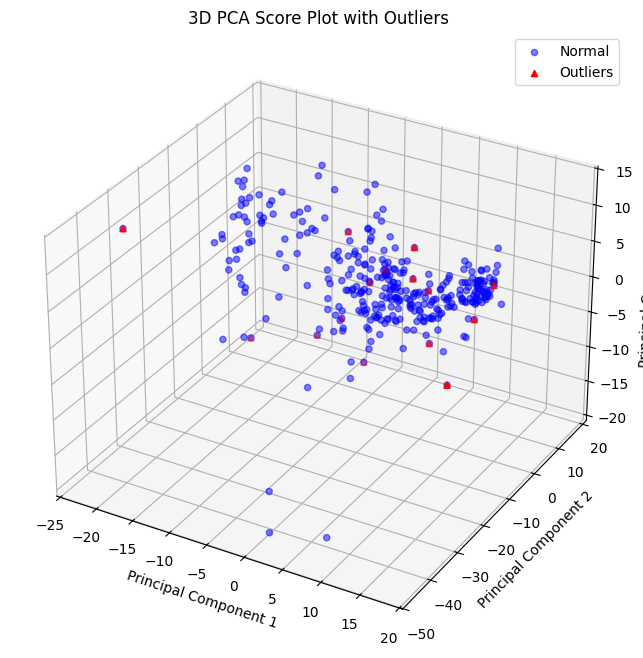

Number of detected outliers: 15
Detected outliers: [  0  40 113 176 213 218 230 231 248 279 280 288 299 315 329]


In [47]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load and preprocess the data
data = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(data)

# Apply PCA for reconstruction (using 3 components for 3D plotting)
pca = PCA(n_components=3)
X_dimensionality_reduced = pca.fit_transform(X_normalized)
X_reconstructed = pca.inverse_transform(X_dimensionality_reduced)

# Calculate reconstruction errors
reconstruction_error = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Set a threshold for the reconstruction error
threshold = 1  # Adjust as needed

# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

# Visual Inspection of PCA Score Plots in 3D
pca_scores = pca.fit_transform(X_normalized)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_scores[:, 0], pca_scores[:, 1], pca_scores[:, 2], c='b', marker='o', alpha=0.5, label='Normal')
ax.scatter(pca_scores[outliers, 0], pca_scores[outliers, 1], pca_scores[outliers, 2], c='r', marker='^', label='Outliers')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Score Plot with Outliers')
ax.legend()

plt.show()

# Print the indices of detected outliers
print(f'Number of detected outliers: {outliers.shape[0]}')
print(f'Detected outliers: {outliers}')

### Using kernel PCA

Linear PCA can only find flat planes/hyperplanes of maximum variance. Kernel PCA can find curved surfaces.

We will now apply Kernel PCA with an RBF (Radial Basis Function) kernel to see if it can capture the structure of our data differently. The gamma parameter defines how far the influence of a single training example reaches (a key hyperparameter for RBF). Notice that there exist many other functions such as 'linear', 'poly', 'sigmoid'.

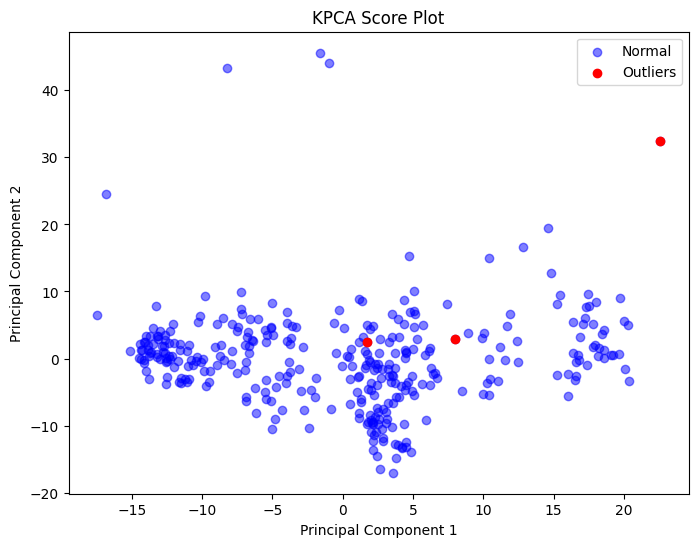

Number of detected outliers: 3
Detected outliers: [  0 288 315]


In [83]:
from sklearn.decomposition import KernelPCA

# Load and preprocess the data
data = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(data)

# Step 1: Perform Kernel PCA
# Kernel functions : 'linear', 'rbf', 'poly', 'sigmoid'.
kpca = KernelPCA(kernel='linear', n_components=7, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_normalized)

# Step 2: Detecting Outliers through Computing Reconstruction Errors
# Reconstruct the data from the reduced kernel PCA space
X_reconstructed = kpca.inverse_transform(X_kpca)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Define a threshold for outliers
threshold = 1  # Adjust as needed
kpca_scores = kpca.fit_transform(X_normalized)
# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

plt.figure(figsize=(8, 6))
plt.scatter(kpca_scores[:, 0], kpca_scores[:, 1], c='b', alpha=0.5, label='Normal')
plt.scatter(kpca_scores[outliers, 0], kpca_scores[outliers, 1], c='r', label='Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('KPCA Score Plot')
plt.show()
# Print the number of detected outliers
print(f'Number of detected outliers: {outliers.shape[0]}')
print(f'Detected outliers: {outliers}')

### **Task 2.1.: Why does the Kernel PCA detects the same outliers as the standard PCA when using a linear kernel?**

Because the linear kernel is equivalent to the regular PCA

### **Task 2.2.: Do you have an idea how we could decide if we should use PCA, kernel PCA and what kernel of kernel PCA?**
I'm not sure but I guess for more complex tasks

### Task 3: Identify the underlying latent factors that explain the observed correlations among several variables using FA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=33e604e267b3b393f47ba790cae80fe6acaaf87ddeea84ae7a45e912b4d847e0
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


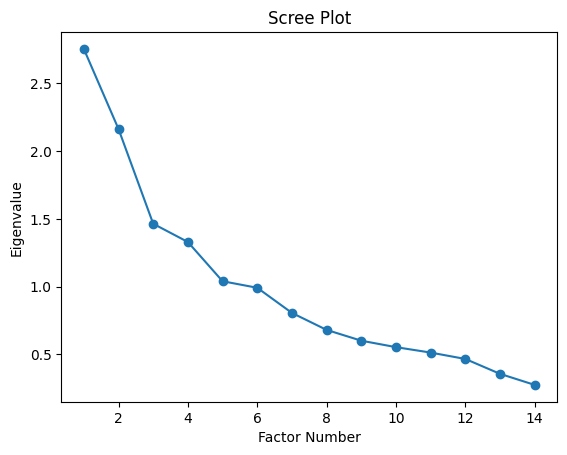

In [32]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Step 1: Data Preprocessing
# Load and preprocess the data
data = pd.read_csv('/content/Dataset 2.csv')

# Step 2: Exploratory Factor Analysis
# Initialize FactorAnalyzer object
fa = FactorAnalyzer()

# # Experiment with different rotation methods (e.g., Varimax, Promax, and Oblimin)
# # Varimax Rotation
# fa.set_params(rotation='varimax')
# fa.fit(data)

# # Promax Rotation
# fa.set_params(rotation='promax')
# fa.fit(data)

# # Oblimin Rotation
fa.set_params(rotation='oblimin')
fa.fit(data)

# Step 3: Determine the Number of Factors
# Kaiser's Criterion
eigenvalues, _ = fa.get_eigenvalues()
num_factors_kaiser = sum(eigenvalues > 1)  # Select factors with eigenvalues > 1

# Scree Plot Examination
plt.scatter(range(1, data.shape[1]+1), eigenvalues)
plt.plot(range(1, data.shape[1]+1), eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.show()

In [33]:
data

,Price,Safety,Exterior_Looks,Space_comfort,Technology,After_Sales_Service,Resale_Value,Fuel_Type,Fuel_Efficiency,Color,Maintenance,Test_drive,Product_reviews,Testimonials
0,4,4,5,4,3,4,5,4,4,2,4,2,4,3
1,3,5,3,3,4,4,3,4,3,4,3,2,2,2
2,4,4,3,4,5,5,5,4,5,4,5,4,4,3
3,4,4,4,3,3,4,5,5,4,4,4,2,5,3
4,5,5,4,4,5,4,5,3,4,5,5,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,4,4,3,4,5,4,4,4,4,4,5,4,5,4
86,4,3,4,4,5,4,3,4,4,5,4,4,5,4
87,4,3,4,4,4,5,3,4,4,3,3,2,4,4
88,4,4,3,4,4,5,3,4,4,4,4,4,4,5


### **Task 3.1.: Identify how many factors are in the dataset**

In [34]:
# Step 4: Compute Factor Loadings
fa.set_params(n_factors=num_factors_kaiser)  # Use the determined number of factors
fa.fit(data)
factor_loadings = fa.loadings_

# Step 5: Interpret the Factors
# (Based on factor loadings and variable names)
# Provide meaningful labels/names to the identified factors based on interpretation
factor_names = [f"Factor {id+1}" for id in range(0,num_factors_kaiser)]  # Adapt as needed

# Print factor loadings
factor_loadings = pd.DataFrame(factor_loadings, index=data.columns, columns=factor_names)
print("Factor Loadings:", factor_loadings)
# print(pd.DataFrame(factor_loadings, index=data.columns, columns=factor_names))

# You can further interpret and label the factors based on the loadings and variable names.

# Additional: Assessing Factorability
bartlett_test_statistic, p_value = calculate_bartlett_sphericity(data)
kmo_score = calculate_kmo(data)

print(f"\nBartlett's Test Statistic: {bartlett_test_statistic}")
print(f"P-value: {p_value}")
print(f"KMO Score: {kmo_score}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Factor Loadings:                      Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
Price                0.578931  0.234152 -0.108803 -0.005588 -0.069328
Safety              -0.306536  0.229736  0.167865  0.065558 -0.243916
Exterior_Looks       0.090185  0.050722  0.026241 -0.542464  0.312042
Space_comfort       -0.022750  0.881709  0.041921 -0.055038  0.034016
Technology           0.000961  0.278548  0.140475  0.061123  0.005776
After_Sales_Service -0.012211  0.040035  0.946527 -0.005035 -0.009768
Resale_Value         0.725386 -0.204593  0.081064 -0.052370 -0.102032
Fuel_Type            0.025645  0.517666  0.107412  0.017839 -0.134947
Fuel_Efficiency      0.381540  0.007924  0.329103  0.226688  0.216041
Color                0.033070 -0.052346  0.016076  0.783525  0.090678
Maintenance          0.552883  0.114794 -0.007430  0.263017  0.006467
Test_drive           0.059225 -0.017722  0.234800 -0.063657  0.438696
Product_reviews      0.331873  0.245901 -0.077326  0.123717  0.351592
Tes

### **Task 3.2. By analysing the factor loadings, specify for each factor what variables it influences**

Factor 1: Price, Resale value, Maintenance

Factor 2: Space comfort, Fuel type

Factor 3: After sale service, Fuel efficiency

Factor 4: Color, -exterior looks

Factor 5: Test drive, Product reviews, Testimonials\
Could be something to do with reputation

### **Task 3.3: Compare the performance of PCA and kernel PCA for dimensionality reduction in dataset 1**

**Your task is to do the following:**

- Experiment with different kernel functions (e.g., Gaussian, polynomial, etc.) and assess their performance for dimensionality reduction.
- Pick the most suitable kernel function to perform kernel PCA for dimensionality reduction of dataset 1.
- Compare the performance of kernel PCA with PCA (baseline from practice task 1) for dimensionality reduction in dataset 1 and propose a suitable method to perform dimensionality reduction in dataset 1.
- Provide a reflection on the dimensionality reduction results obtained using PCA and kernel PCA. Was PCA sufficient to capture the data’s structure? Which one would you choose to perform your dimensionality reduction task and why?

Text(0.5, 1.0, 'Kernel PCA (Polynomial)')

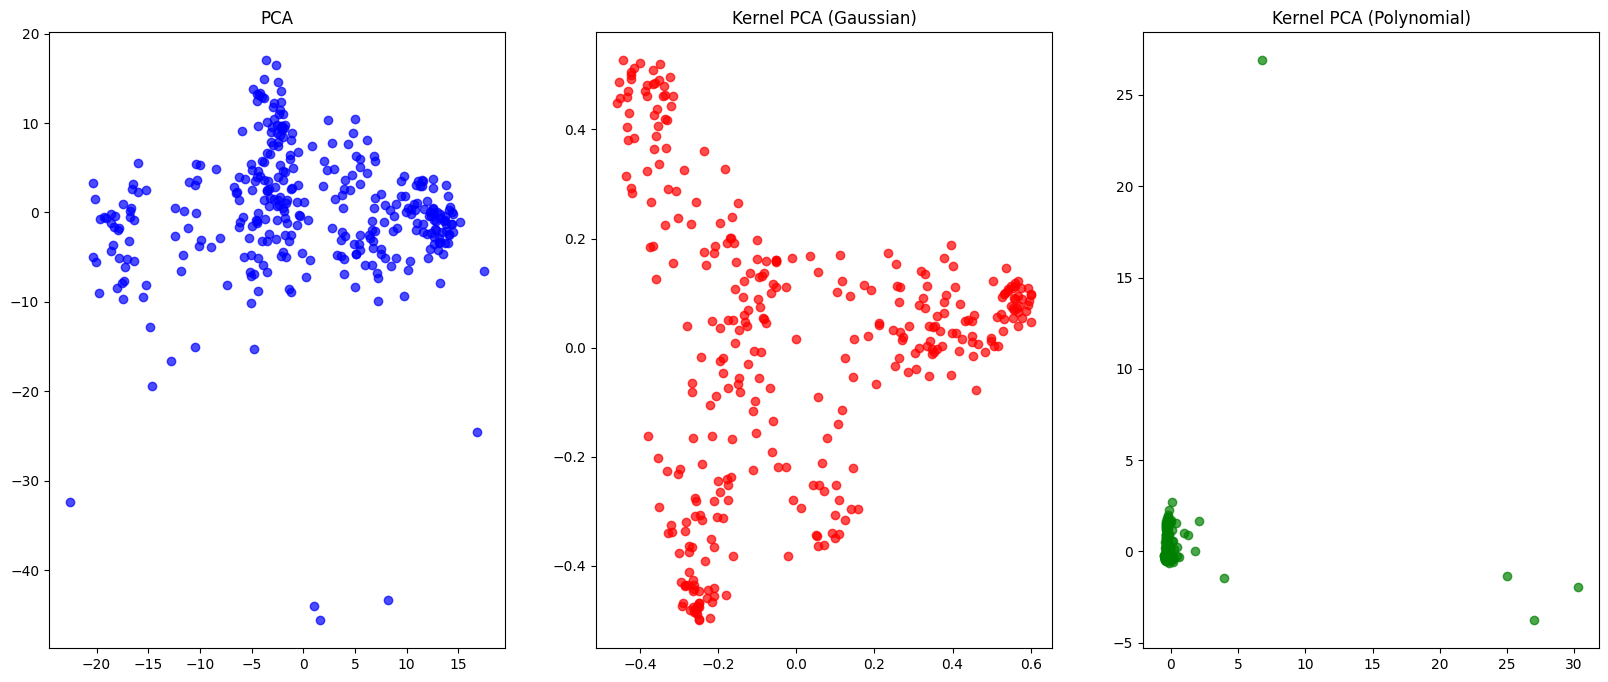

In [55]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

input_df = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(input_df)

# Step 1: Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Set the desired number of components
pca_result = pca.fit_transform(data_scaled)

# Step 2: Perform Kernel PCA with different kernel functions
# kernel functions : 'linear', 'rbf', 'poly', 'sigmoid'

kernel_pca_gaussian = KernelPCA(kernel='rbf', n_components=2)  # Gaussian kernel
kernel_pca_polynomial = KernelPCA(kernel='poly', n_components=2)  # Polynomial kernel

kpca_gaussian_result = kernel_pca_gaussian.fit_transform(data_scaled)
kpca_polynomial_result = kernel_pca_polynomial.fit_transform(data_scaled)

# Plot the different PCA functions
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='b', marker='o', alpha=0.7)
plt.title('PCA')

plt.subplot(1, 3, 2)
plt.scatter(kpca_gaussian_result[:, 0], kpca_gaussian_result[:, 1], c='r', marker='o', alpha=0.7)
plt.title('Kernel PCA (Gaussian)')

plt.subplot(1, 3, 3)
plt.scatter(kpca_polynomial_result[:, 0], kpca_polynomial_result[:, 1], c='g', marker='o', alpha=0.7)
plt.title('Kernel PCA (Polynomial)')


In [36]:
pca.explained_variance_ratio_

array([0.31725246, 0.19340224])

Ok so I need to play with these and find a way to evaluate the different methods and then get results and stuff like that

### Regular PCA testing
I will run some tests on regular PCA with different components to see when we can get a substantial difference in results.

PCA with 2 components:
Total explained variance (%): 51.06547011051293
Time taken: 0.000044 seconds

PCA with 3 components:
Total explained variance (%): 59.36376279663236
Time taken: 0.000010 seconds

PCA with 4 components:
Total explained variance (%): 64.80829992230797
Time taken: 0.000011 seconds

PCA with 5 components:
Total explained variance (%): 69.36334246032236
Time taken: 0.000010 seconds

PCA with 6 components:
Total explained variance (%): 72.37532789102123
Time taken: 0.000011 seconds

PCA with 8 components:
Total explained variance (%): 76.03236281013312
Time taken: 0.000012 seconds

PCA with 10 components:
Total explained variance (%): 78.69064977482032
Time taken: 0.000011 seconds

PCA with 15 components:
Total explained variance (%): 82.31738983545122
Time taken: 0.000011 seconds

PCA with 25 components:
Total explained variance (%): 86.22869382823326
Time taken: 0.000020 seconds

PCA with 50 components:
Total explained variance (%): 91.15968757609272
Time taken: 0.00

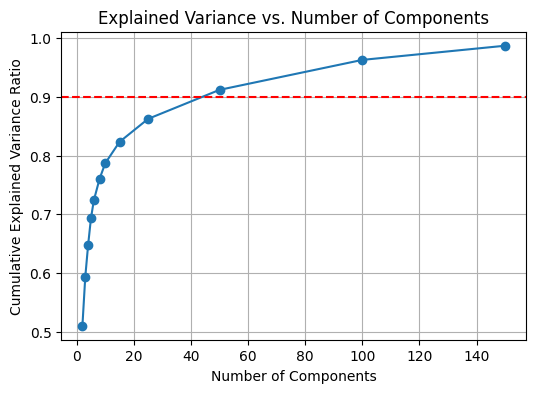

In [113]:
import time
var_explained = []
components=[2,3,4,5,6,8,10,15,25,50,100,150]
# data_scaled is the df to analyze

for c in components:
  start = time.perf_counter()
  pca = PCA(n_components=c)
  end = time.perf_counter()

  pca_result = pca.fit_transform(data_scaled) # get the values of the principal components
  expl_var = pca.explained_variance_ratio_ # calculates the percentage of variance explained by the PC
  var_explained.append(sum(expl_var))

  print(f'PCA with {c} components:')
  print(f'Total explained variance (%): {sum(expl_var*100)}')
  print(f'Time taken: {end - start:0.6f} seconds')
  print()


plt.figure(figsize=(6, 4))
plt.plot(components, var_explained, marker='o', linestyle='-')
plt.axhline(y=0.90, color='red', linestyle='--', label='0.9')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

We can see that there is no substantial difference in execution time between the different number of components, so I could think that it would be benefitial to just use more components, let's test on more complex tasks.

### Outlier detection
I will do some reconstructions in order to see which kernel method (including linear) will manage to reconstruct the data more faithfully.

In [121]:
# Step 1: Perform Kernel PCA
kernel_functions = ['linear', 'rbf', 'poly', 'sigmoid']
components=[2,4,6,8,10,12,15]
outliers_df = pd.DataFrame(index=components, columns=kernel_functions)
times_df = pd.DataFrame(index=components, columns=kernel_functions)

for f in kernel_functions:
  for c in components:
    start = time.perf_counter()
    # step 1: Do the PCA
    kpca = KernelPCA(kernel=f, n_components=c, fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(data_scaled)

    # Step 2: Detecting Outliers through Computing Reconstruction Errors
    # Reconstruct the data from the reduced kernel PCA space
    X_reconstructed = kpca.inverse_transform(X_kpca)

    # Calculate the reconstruction error
    reconstruction_error = np.mean(np.square(data_scaled - X_reconstructed), axis=1)

    # Define a threshold for outliers
    threshold = 1  # Adjust as needed
    kpca_scores = kpca.fit_transform(data_scaled)

    # Identify outliers
    outliers = np.where(reconstruction_error > threshold)[0]
    outliers_df.loc[c,f] = outliers.shape[0]

    end = time.perf_counter()
    times_df.loc[c, f] = "%.6f" % (end - start)
print(outliers_df)
print(times_df)

   linear rbf poly sigmoid
2      19  78   40      88
4       9  76   19      87
6       4  75   16      87
8       3  75   13      87
10      0  76    9      87
12      0  76    6      87
15      0  75    4      87
      linear       rbf      poly   sigmoid
2   0.279084  0.336219  0.194429  0.190267
4   0.299272  0.226916  0.228184  0.167960
6   0.272279  0.249749  0.148134  0.382905
8   0.218433  0.092871  0.105631  0.153471
10  0.348363  0.212962  0.273723  0.150712
12  0.256904  0.123893  0.165166  0.244045
15  0.244154  0.178929  0.221512  0.171673


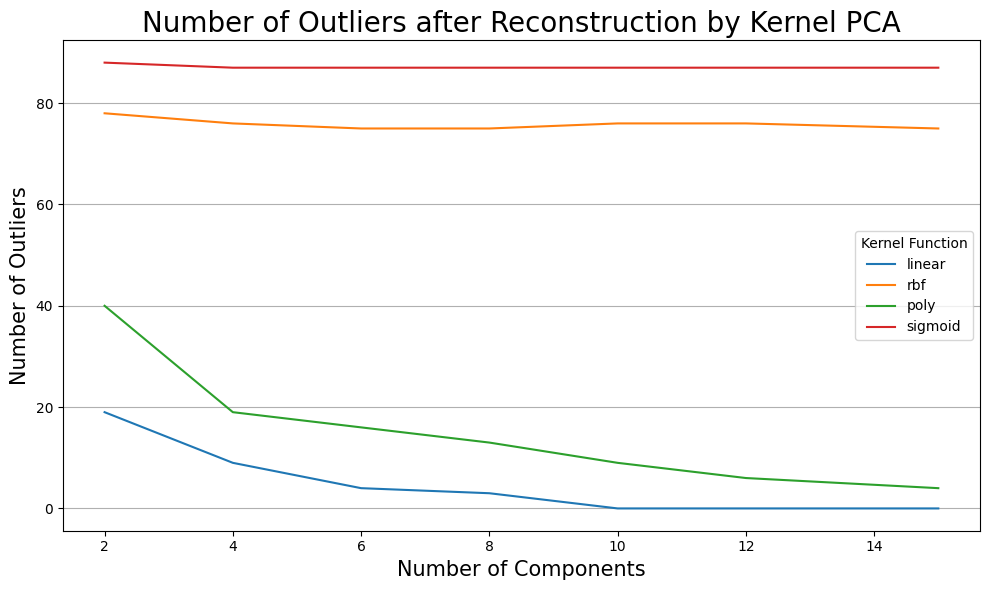

In [108]:
outliers_df.plot(kind='line', figsize=(10, 6))
plt.title('Number of Outliers after Reconstruction by Kernel PCA',size=20)
plt.xlabel('Number of Components',size=15)
plt.ylabel('Number of Outliers',size=15)
plt.xticks(rotation=0)
plt.legend(title='Kernel Function')
plt.grid(axis='y')
plt.tight_layout()
plt.show()